In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import diags
from numba import njit

from time import time 
from tqdm.notebook import trange

# Boundary conditions

In exercise 5, we looked at the diffusion equation with constant diffusivity and reflecting and absorbing boundary conditions. We will now look at some more advanced examples.

Note that while implementing boundary conditions in an SDE solver may have seemed pretty straightforward in Exercise 5, this is not a topic where it is easy to find good reference literature.

As an example, Kloeden & Platen contains the word "reflect" in the context of a boundary exactly once, in the section for suggested further reading:

![excerpt from K&P](fig/reflect1.png)
![excerpt from K&P](fig/reflect2.png)

## Reflecting boundary conditions -- the Skorokhod problem

Solving an SDE on a domain with a reflecting boundary condition is called a Skorokhod problem, after Anatoly Skorokhod who wrote two early papers on this topic (Skorokhod, 1961, 1962). In particular, Skorokhod (1961) describes how an SDE with a reflecting boundary can be formally described by adding a term which only contributes at the boundary, and which causes any trajectory that touches the boundary to be _immediately_ reflected, such that the particle spends no time _at_ the boundary.

Let's say we have a process $X_t$, described by the SDE (on integral form)

$$
X_t = X_0 + \int_{t_0}^t a(X_s, s) \, \mathrm{d} s + \int_{t_0}^t b(X_s, s) \, \mathrm{d}W_s,
$$

where we want to enforce the additional constraint that $X_t \geq 0$ for all $t$ (i.e., a reflecting boundary at 0). To achieve this, we solve the modified system

$$
X_t = X_0 + \int_{t_0}^t a(X_s, s) \, \mathrm{d} s + \int_{t_0}^t b(X_s, s) \, \mathrm{d}W_s + \zeta_t,
$$

where $\zeta_t$ is called the reflection function, and has the property that it is an increasing function, which increases only when $X_t=0$, and by a sufficient amount to immediately push $X_t$ away from the boundary.

However, the focus of Skorohkod was on proving the existence and uniqueness of solutions to this modified system and not on numerical solutions. Numerically, it is extremely unlikely that we will have exactly $X_t=0$, and so it is not straightforward to implement this approach.

Below, I attempt to illustrate the idea, but note that this is only meant as an illustration of the idea, not an attempt at a proper implementation.

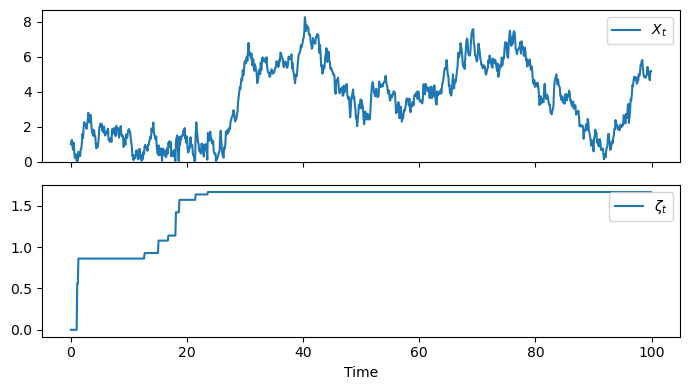

In [12]:
Nt = 1000
dt = 0.1
X = np.zeros(Nt)
zeta = np.zeros(Nt)
X[0] = 1

for i in range(1, Nt):
    X[i] = X[i-1] + np.random.normal(loc=0, scale=np.sqrt(dt))
    if X[i] < 0:
        zeta[i:] += -X[i]
        X[i] = X[i] + zeta[i]
        
t = dt*np.arange(Nt)
        
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(7,4))
ax[0].plot(t, X, label='$X_t$')
ax[1].plot(t, zeta, label='$\zeta_t$')
ax[0].set_ylim(ymin=0)
ax[1].set_xlabel('Time')
ax[0].legend()
ax[1].legend()
plt.tight_layout()

## Reflecting boundary conditions

### A pragmatic numerical implementation: Simple reflection

The probably simplest and most obvious approach to handle reflecting boundary conditions is to just check if the particle is outside the boundary after every step, and if it is, reflect it about the boundary. For a one-dimensional process $X_t$ and boundaries at $x_{min}$ and $x_{max}$, that means we do the following after every step:

\begin{align}
X_t = \left\{ \begin{array}{ccc}X_t + 2(x_{min} - X_t) & \mathrm{if} & X_t < x_{min} \\ X_t + 2(x_{max} - X_t) & \mathrm{if} & X_t > x_{max} \end{array} \right.
\end{align}

This worked very well for the problem in Exercise 5, but what about more general problems.

Below, we test this approach on a case with non-constant diffusivity. We recall from last time that the diffusion equation with variable diffusivity is

$$ \frac{\partial p}{\partial t}  = \frac{\partial }{\partial x} \left( K \frac{\partial p}{\partial x}\right). $$

and that the corresponding SDE is

$$ \mathrm{d} X_t = \left. \frac{\partial K}{\partial x} \right|_{x=X_t} \, \mathrm{d}t + \sqrt{2K(X_t)} \, \mathrm{d}W. $$


In [25]:
# The Euler-Maruyama method
def EM(X, t, dt, a, b, dW=None):
    # Euler-Maruyama method, with drift a(X, t) and diffusion b(X, t)
    # Unless provided, generate random dW, Gaussian with mean=0 and variance=dta
    # and the correct number of elements
    if dW is None:
        dW = np.random.normal(loc=0, scale=np.sqrt(dt), size=X.shape)
    # Calculate and return next value
    return X + a(X, t)*dt + b(X, t)*dW

# A solver wrapper that can take a boundary handling function
# as an extra argument
def solve_SDE(X0, tmax, dt, a, b, solver, boundary=None, W=None):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in trange(1, Nt):
        # Call solver, with pre-computed W if available
        if W is None:
            X[n,:] = solver(X[n-1,:], t, dt, a, b)
        else:
            # Obtain increment from pre-computed Wt
            dW = W[n] - W[n-1]
            X[n,:] = solver(X[n-1,:], t, dt, a, b, dW=dW)
        # If provided, apply the function that implements behaviour at the boundary
        if boundary is not None:
            X[n,:] = boundary(X[n,:])
        t += dt
    return X

def reflect(X, xmin=0, xmax = 2):
    # Reflect as many times as needed, until all particles are inside
    while np.any((X < xmin) | (X > xmax)): # Note that | is shorthand for np.logical_or in this case
        X = np.where(X < xmin, X+2*(xmin - X), X)
        X = np.where(X > xmax, X+2*(xmax - X), X)
    return X

  0%|          | 0/400 [00:00<?, ?it/s]

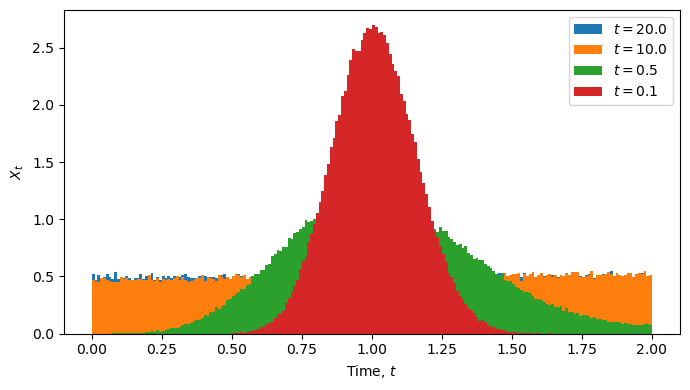

In [41]:
# Define K(x) and its derivative

K0 = 1e-1

def K(x):
    # Choosing a linear function of x
    return K0*x + 0.01

def dKdx(x):
    # Analytical derivative in this simple case
    return K0

# Implementing a and b as functions
def a(X, t):
    return dKdx(X)

def b(X, t):
    return np.sqrt(2*K(X))

# Several initial values leads to several solutions
Np = 200000
X0 = 1.
# Integration time
tmax = 20
# timestep
dt = 0.05

X = solve_SDE(X0*np.ones(Np), tmax, dt, a, b, EM, boundary=reflect)

times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(0, 2, 201, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the solution
fig = plt.figure(figsize = (7, 4))

for t in [20, 10, 0.5, 0.1]:
    # Find closest time we have solutions for
    it = np.argmin(np.abs(t - times))
    plt.hist(X[it,:], bins=bins, label=f'$t={times[it]}$', density=True)
    
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-0.1, 2.1)
plt.legend()
plt.tight_layout()

## Intermezzo: The well-mixed condition

The steady-state solution to the diffusion equation (with reflecting / no-flux boundaries) is $p(x) = \mathrm{const}.$ We can easily confirm that this is the case, by inserting any constant $p(x)$ into the PDE:

$$ \frac{\partial p}{\partial t}  = \frac{\partial }{\partial x} \left( K \frac{\partial p}{\partial x}\right). $$

If $\frac{\partial p}{\partial x} = 0$, then the entire right-hand side is zero, which means that $\frac{\partial p}{\partial t}=0$, and thus $p(x)$ will not change with time.

Thus, if we create an initial condition where the particles are uniformly distributed, they should remain uniformly distributed. Thomson (1987) introduced this as a (necessary, but not sufficient) criterion that an implementation of a stochastic model must satisfy to be consistent with the corresponding PDE.

Below, we demonstrate numerically that the Euler-Mauryama scheme with simple reflection at the boundaries does not satisfy the well-mixed condition for las large $\Delta t$, but that the discrepancy becomes smaller as $\Delta t$ becomes smaller.

  0%|          | 0/20 [00:00<?, ?it/s]

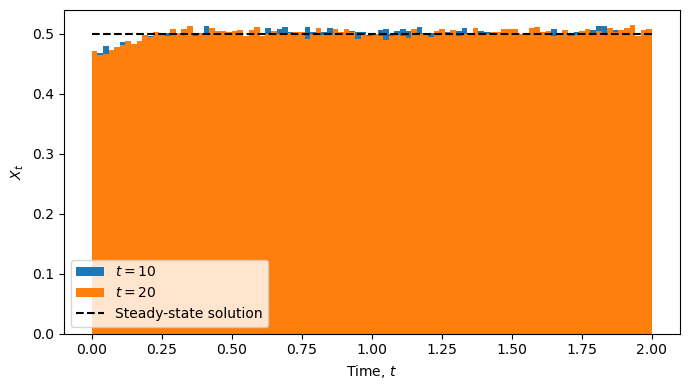

In [63]:
# Define K(x) and its derivative

K0 = 1e-1

def K(x):
    # Choosing a linear function of x
    return K0*x + 0.01

def dKdx(x):
    # Analytical derivative in this simple case
    return K0

# Implementing a and b as functions
def a(X, t):
    return dKdx(X)

def b(X, t):
    return np.sqrt(2*K(X))

# Several initial values leads to several solutions
Np = 1000000
X0 = np.random.uniform(low=0, high=2, size=Np)
# Integration time
tmax = 20
# timestep
dt = 1

X = solve_SDE(X0*np.ones(Np), tmax, dt, a, b, EM, boundary=reflect)

times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(0, 2, 101, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the solution
fig = plt.figure(figsize = (7, 4))

for t in [10, 20]:
    # Find closest time we have solutions for
    it = np.argmin(np.abs(t - times))
    plt.hist(X[it,:], bins=bins, label=f'$t={times[it]}$', density=True)
    
plt.plot([0,2], [0.5, 0.5], '--', c='k', label='Steady-state solution')
    
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-0.1, 2.1)
plt.legend()
plt.tight_layout()

### Another illustration: the first moment (mean particle position) as a function of time

Below, we plot the mean particle position as a function of time, for the same model run as above. The particles were initially uniformly distributed between 0 and 2, which means that $\langle X_0 \rangle = 1$. If the particles had remained uniformly distributed, the mean particle position should remain 1.

(Of course, even if the well-mixed condition was fulfilled, the mean particle position would fluctuate randomly, but in this case it is systematically larger than 1, by an amount larger than the error predcited by the central limit theorem.)

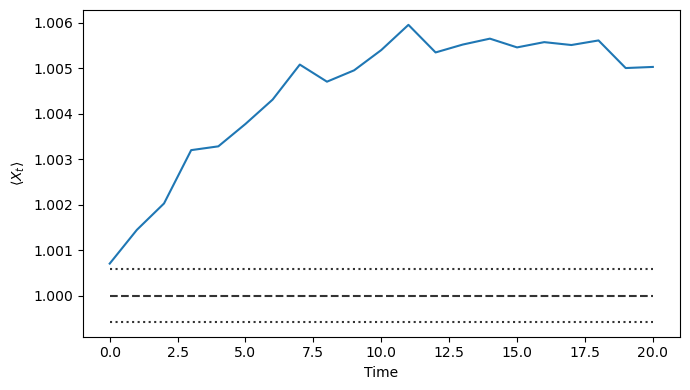

In [64]:
fig = plt.figure(figsize=(7,4))

plt.plot(times, np.mean(X, axis=1))
plt.plot(times, np.ones_like(times), '--', c='k', alpha=0.8)
plt.plot(times, np.ones_like(times) + np.sqrt(np.var(X[0,:])/Np), ':', c='k', alpha=0.8)
plt.plot(times, np.ones_like(times) - np.sqrt(np.var(X[0,:])/Np), ':', c='k', alpha=0.8)

plt.ylabel('$\langle X_t \\rangle$')
plt.xlabel('Time')
plt.tight_layout()

## Error in the first moment as a function of timestep

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

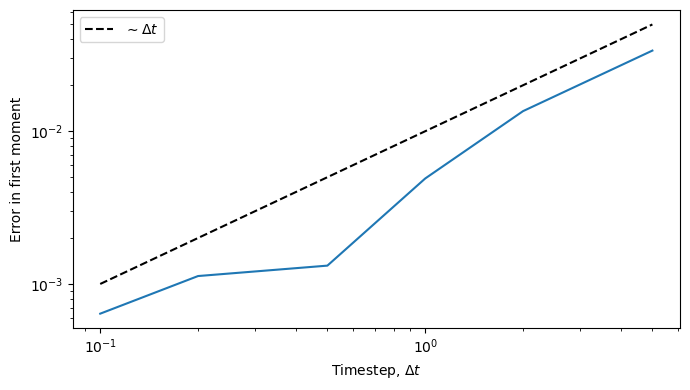

In [67]:
# Define K(x) and its derivative

K0 = 1e-1

def K(x):
    # Choosing a linear function of x
    return K0*x + 0.01

def dKdx(x):
    # Analytical derivative in this simple case
    return K0

# Implementing a and b as functions
def a(X, t):
    return dKdx(X)

def b(X, t):
    return np.sqrt(2*K(X))

# Several initial values leads to several solutions
Np = 1000000
X0 = np.random.uniform(low=0, high=2, size=Np)
# Integration time
tmax = 20


timesteps = np.array([0.1, 0.2, 0.5, 1, 2, 5])
errors = np.zeros(len(timesteps))

for i, dt in enumerate(timesteps):
    X = solve_SDE(X0*np.ones(Np), tmax, dt, a, b, EM, boundary=reflect)
    errors[i] = np.abs( np.mean(X[-1,:]) - 1 )


# Plot the results
fig = plt.figure(figsize = (7, 4))
plt.plot(timesteps, errors)
plt.plot(timesteps, 1e-2*timesteps, '--', c='k', label='$\sim \Delta t$')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timestep, $\Delta t$')
plt.ylabel('Error in first moment')
plt.tight_layout()

## Back to reflecting boundary implementations:

### A more complicated, but also less accurate, scheme: Rejecting crossing steps, and retrying with shorter timestep

In many applications, particularly related to turbulence, the diffusivity will go down as we approach a boundary. The idea is therefore that if the timestep is sufficiently short, there will be few boundary crossings. Hence, one might be inspired to try rejecting those steps that cross the boundary, and retrying them with a smaller timestep. However, this does not work particularly well, as shown below.

The problem is that once we start rejecting steps, we are skewing the Gaussian distribution, which introduces a bias in the results.

In [81]:
# A solver wrapper that implements the rejection approach
# Do not use this
def solve_SDE_reject(X0, tmax, dt, a, b, solver, xmin, xmax):
    # A simple solve function (assumes dt evenly divides tmax)
    # Calculate number of timsteps (including 0 and tmax)
    Nt = int(tmax/dt) + 1
    # If X0 is not an array, turn it into a 1-element array
    if not isinstance(X0, np.ndarray):
        X0 = np.array([X0])
    # Arrays to track solution
    X = np.zeros((Nt, *X0.shape))
    X[0,:] = X0
    t = 0
    for n in trange(1, Nt):
        # Call solver
        X[n,:] = solver(X[n-1,:], t, dt, a, b)
        # If any particles crossed, reject the step and try again with half the timestep
        # and then use simple reflection if still needed
        # Find particles that are outside
        mask = (X[n,:] < xmin) | (X[n,:] > xmax)
        # Try again with half the timestep, first step
        X[n,mask] = solver(X[n-1,mask], t, dt/2, a, b)
        # Reflect if needed
        X[n,mask] = reflect(X[n,mask], xmin=xmin, xmax=xmax)
        # Try again with half the timestep, second step
        X[n,mask] = solver(X[n,mask], t, dt/2, a, b)
        # Reflect if needed
        X[n,mask] = reflect(X[n,mask], xmin=xmin, xmax=xmax)
        t += dt
    return X
    

  0%|          | 0/20 [00:00<?, ?it/s]

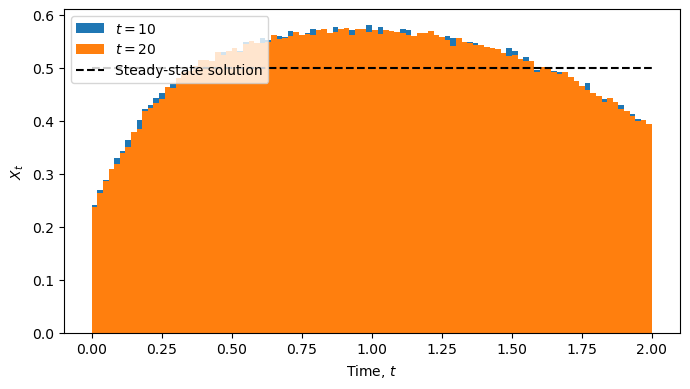

In [82]:
# Define K(x) and its derivative

K0 = 1e-1

def K(x):
    # Choosing a linear function of x
    return K0*x + 0.01

def dKdx(x):
    # Analytical derivative in this simple case
    return K0

# Implementing a and b as functions
def a(X, t):
    return dKdx(X)

def b(X, t):
    return np.sqrt(2*K(X))

# Several initial values leads to several solutions
Np = 1000000
X0 = np.random.uniform(low=0, high=2, size=Np)
# Integration time
tmax = 20
# timestep
dt = 1

X = solve_SDE_reject(X0*np.ones(Np), tmax, dt, a, b, EM, xmin=0, xmax=2)

times = dt*np.arange(X.shape[0])
bins, dx =np.linspace(0, 2, 101, retstep=True) # bins
mids=bins[:-1] + (bins[1]-bins[0])/2 # midpoints of the bins

# Plot the solution
fig = plt.figure(figsize = (7, 4))

for t in [10, 20]:
    # Find closest time we have solutions for
    it = np.argmin(np.abs(t - times))
    plt.hist(X[it,:], bins=bins, label=f'$t={times[it]}$', density=True)
    
plt.plot([0,2], [0.5, 0.5], '--', c='k', label='Steady-state solution')
    
plt.xlabel('Time, $t$')
plt.ylabel('$X_t$')
plt.xlim(-0.1, 2.1)
plt.legend()
plt.tight_layout()

### An even more intricate approach: The Lépingle scheme

Lépingle (1993, 1995) makes the following observation: If we check if a particle is outside the boundary at $t$, and again at $t + \Delta t$, we do not know if it could have been outside the boundary in the meantime. But, from the properties of the Brownian motion, and under certain assumptions, we can find the probability that the particle has been outside, and the distribution of the distance outside the boundary. Then we can take that distance into account in our scheme. He describes a variant of the Euler-Mauryama scheme that implements this.


#### Theory:

Consider a particle whose position $X_t$ develops according to the SDE

$$ \mathrm{d} X = a(X, t) \, \mathrm{d}t + b(X, t) \, \mathrm{d}W.$$

Say that we have the position $X_n$ at time $t_n$, and $X_{n+1}$ at time $t_{n+1}$. Since the position is a continous function of time, we know for sure that $X_t$ has had all the values between $X_{n}$ and $X_{n+1}$ on the interval from $t_n$ to $t_{n+1}$, but how about values outside that range?

![A sketch of the motivation for the Lépingle scheme](./fig/lepingle_motivation.png)

Lets say that we "freeze" the coefficients, $a$ and $b$ at the values at time $t_n$, and call them $a_n=a(X_n, t_n)$ and $b_n=b(X_n, t_n)$, and consider the random variable

$$ S_n = \sup_{t_n \leq t \leq t_{n+1}} \big[ a_n\cdot(t-t_n) + b_n \cdot(t -t_n) \big], $$

where $\sup_{t_n \leq t \leq t_{n+1}}$ means the largest value the expression has in the interval $[t_n, t_{n+1}]$. This variable can be shown to have the same distribution as the variable

$$ Y_n = \frac{1}{2}\big[a_n \Delta t + b_n \Delta W_n + \sqrt{b_n^2 V_n + (a_n \Delta t + b_n \Delta W_n)^2} \big], $$

where $\Delta W_n = W_{t_{n+1}} - W_{t_n}$, and $V_n$ is an exponentially distributed random variable with parameter $(2\Delta t)^{-1}$.

The idea is then that we generate this additional random varible, $Y_n$, which represents the extreme value of the trajectory in  between the two known points, $(X_n, t_n)$ and $(X_{n+1}, t_{n+1})$ (the same in either direction).

Say the reflecting boundary is at $x=0$. Then, if $Y_n - X_n > 0$, we add an offset $Y_n - X_n$ to the solution. It is possible to show that this is always enough to make sure $X_{n+1} > 0$, but a contribution will frequently also be added to solutions that did not end up outside (which was indeed the point).

If I understand the paper (Lépingle, 1995) correctly, the point of this scheme is that an Euler scheme with simple reflection cannot quite reach strong order 1/2, whereas the Lépingle scheme does.

Personally, though, I have not found the Lépingle scheme to be more accurate than simple reflection in the numerical tests I have done.

## Link between SDEs on domains with boundaries and PDE boundary value problems


### Laplace equation


The Laplace equation

$$ \nabla^2 \phi = 0 $$

is an example of a second-order linear partial differential equation, and belongs to the class known as *elliptic PDEs*. These equations do not describe a time development, but rather they describe the steady-state of some function $\phi$ on some domain with some boundary conditions. (For example, the Laplace equation describes the steady-state solution of the heat equation with constant diffusivity and fixed (in time) temperature at the boundaries.

### Example: The Laplace equation in 2D

In two dimensions, the Laplace equation becomes

$$ \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = 0. $$

We wish to solve the equation on the domain $x \in [0, 2]$, $y \in [0, 1]$. We discretise space, such that

$$ x_n = n \Delta x, \;\; y_n = n \Delta y.$$

We also define the shorthand notation

$$ \phi_{i,j} = \phi(x_i, y_j).$$

The boundary conditions are

$$ \phi(x = 0, y) = 0, \;\; \phi(x = 2, y) = 0, \;\; \phi(x, y=0) = 0, \;\; \phi(x, y=1) = 1. $$


#### Discretise the partial derivatives

We approximate the partial derivatives using finite differences:

$$ \left. \frac{\partial^2 \phi(x, y)}{\partial x^2} \right|_{x_i, y_j} \approx \frac{\phi(x_{i+1}, y_j) - 2\phi(x_i,y_j) + \phi(x_{i-1}, y_j)}{\Delta x^2},$$

$$ \left. \frac{\partial^2 \phi(x, y)}{\partial y^2} \right|_{x_i, y_j} \approx \frac{\phi(x_i, y_{j+1}) - 2\phi(x_i,y_j) + \phi(x_i, y_{j-1})}{\Delta y^2}.$$

Inserting this into the Poisson equation, we obtain the following discrete version:

$$ \frac{\phi(x_{i+1}, y_j) - 2\phi(x_i,y_j) + \phi(x_{i-1}, y_j)}{\Delta x^2} + \frac{\phi(x_i, y_{j+1}) - 2\phi(x_i,y_j) + \phi(x_i, y_{j-1})}{\Delta y^2} = 0. $$

where the discrete delta function is given by

$$ \delta(x_i - x_k, y_j - y_l) = \left\{ \begin{array}{ccc} \frac{1}{\Delta x \Delta y} & \mathrm{if} & i=k \;\mathrm{and}\; j=l \\ 0 & \mathrm{otherwise} \end{array}\right. . $$

Choosing for simplicity $ \Delta x = \Delta y$, we can rewrite this into an equation for $\phi_{i,j}$:

$$ \phi_{i,j} = \frac{\Delta x}{4} \left[ \phi_{i+1, j} + \phi_{i-1, j} + \phi_{i, j+1} + \phi_{i, j-1} \right]. $$

Here we have two options:
* Treating $\mathbf{\phi}$ as a "flattened" vector containing all the points in the 2D grid, and rewrite into matrix form: $\mathbf{A} \mathbf{\phi} = \mathbf{f}$. Here, $\mathbf{A}$ will be a sparse matrix (since each point is only "connected" to four other points, each row in $\mathbf{A}$ will only have five non-zero entries), and the system can be solved with direct or iterative methods (see notebook 10).
* Apply the above directly as an iterative method, starting from an initial guess for all $\phi_{i,j}$ (with some optional variations, see below).

In [84]:
# Boundaries of the domain
Xmin = 0
Xmax = 2
Ymin = 0
Ymax = 1
# Choose number of points (this then specifies the grid spacing, could also go the opposite way)
Nx = 201
Ny = 101
X, dx = np.linspace(Xmin, Xmax, Nx, retstep = True)
Y, dy = np.linspace(Ymin, Ymax, Ny, retstep = True)
# Confirm that dx = dy as we wanted
assert np.abs(dx - dy) < 1e-14


# Array to hold solution
phi_now  = np.zeros((Nx, Ny))

# Boundaries
phi_now[ 0, :] = 0.0
phi_now[-1, :] = 0.0
phi_now[ :, 0] = 0.0
phi_now[ :,-1] = 1.0

# Initial guess in the interior:
phi_now[1:Nx-1, 1:Ny-1] = 0.0
# An extra array for iterations
phi_next = phi_now.copy()

# Tolerance, to determine when solution is close enough
tol = 1e-3
# variable to measure error:
err = 2*tol

# Now we are ready to proceed with the update loop
tic = time()
while err > tol:
    # Calculate next step, updating interior cells only
    # then copy: next -> current
    phi_next[1:Nx-1, 1:Ny-1] = (
        phi_now[2:,1:Ny-1] + phi_now[:Nx-2,1:Ny-1] 
        +   phi_now[1:Nx-1,2:] + phi_now[1:Nx-1,:Ny-2]
        )/4
    
    # Calculate error:
    err = np.linalg.norm(phi_next - phi_now)
    print('Error: %.3e' % err, '\r', end = '')
    
    # Copy (after calculating error)
    phi_now = phi_next.copy()

toc = time()
print('The calculation took %s seconds' % (toc - tic))

The calculation took 1.0658752918243408 seconds


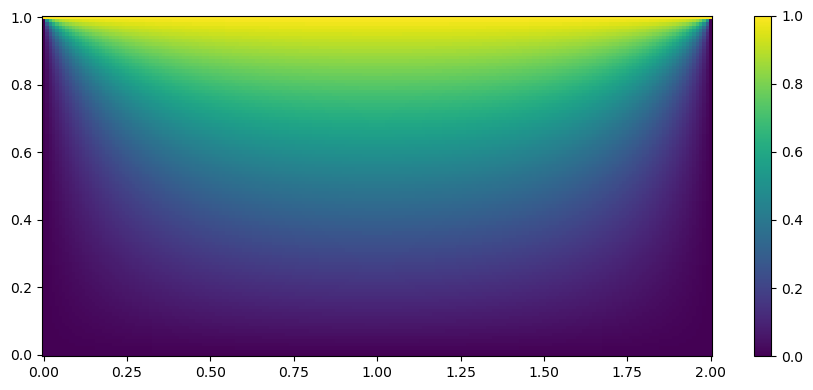

In [85]:
# Plotting as heatmap
fig = plt.figure(figsize = (9,4))
mesh = plt.pcolormesh(X, Y, phi_now.T)
plt.colorbar(mesh)
plt.tight_layout()

## Solving with SDEs

It turns out that if we start out a 2D Wiener process at some point $(x, y)$ on the same domain as above, then the solution of the Laplace equation in that point, $\phi(x, y)$ is the same as the expectation value of $\phi(x', y')$, where $(x', y')$ is the location where the Wiener process first hits the boundary of the domain, and $\phi(x', y')$ is the boundary value at that point.

For a simple implementation, we create a grid of points, start out multiple Wiener processes from each point, and whenever they hit the boundary we make note of the value of the boundary where they hit (and then discard the rest of that process).


In [108]:
from numba import njit

In [109]:
@njit
def wiener_poisson(Nx, Ny, Np, dt, Tmax=10):
    # Values at the boundaries (not the positions, those are fixed)
    xmin=0
    xmax=0
    ymin=0
    ymax=1
    # Grid resolution
    dx = 2/Nx
    dy = 1/Ny
    # Array to hold solution
    phi = np.zeros((Nx, Ny))
    # Count how many particles did not hit the boundary
    count = 0
    
    # Lots of nested loops
    for i in range(Nx):
        for j in range(Ny):
            for n in range(Np):
                X = np.array([dx*(0.5+i), dy*(0.5+j)])
                t = 0
                while t <= Tmax:
                    t += dt
                    X += np.random.normal(loc=0, scale=np.sqrt(dt), size=2)
                    # Check for boundary crossings
                    if X[0] < 0:
                        phi[i,j] += xmin/Np
                        break
                    if X[0] > 2:
                        phi[i,j] += xmax/Np
                        break
                    if X[1] < 0:
                        phi[i,j] += ymin/Np
                        break
                    if X[1] > 1:
                        phi[i,j] += ymax/Np
                        break
                if t >= Tmax:
                    count += 1

    print(count, ' particles did not hit the boundary')
    return phi

In [118]:
phi = wiener_poisson(100, 50, 100, 0.1, Tmax=100)
X_ = np.linspace(0, 2, phi.shape[0]+1)
Y_ = np.linspace(0, 1, phi.shape[1]+1)

0  particles did not hit the boundary


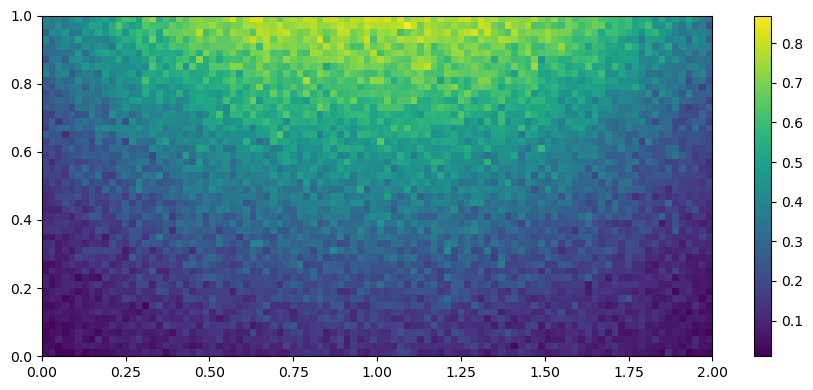

In [119]:
# Plotting as heatmap
fig = plt.figure(figsize = (9,4))
mesh = plt.pcolormesh(X_, Y_, phi.T)
plt.colorbar(mesh)
plt.tight_layout()

# References

Kloeden & Platen (1999), _Numerical Solution of Stochastic Differential Equations_. https://link.springer.com/book/10.1007/978-3-662-12616-5

Skorokhod, A. V. (1961). "Stochastic equations for diffusion processes in a bounded region". _Theory of Probability & Its Applications_, 6(3), 264-274. https://doi.org/10.1137/1106035

Skorokhod, A. V. (1962). "Stochastic equations for diffusion processes in a bounded region. II". _Theory of Probability & Its Applications_, 7(1), 3-23. https://doi.org/10.1137/1107002

Thomson, D. J. (1987). "Criteria for the selection of stochastic models of particle trajectories in turbulent flows". _Journal of fluid mechanics_, 180, 529-556. https://doi.org/10.1017/S0022112087001940 

